# Analyze arduino serial dump from touchscreen

In [1]:
import numpy as np
import pandas as pd
import pylab as pl
pl.style.use('ggplot')

The serial dump is stored in the `data` folder a csv file called `scan_data_gain200_thumb.csv`. So when this recording was obtained, the gain (FT5206 register 0x07) was set to 200, and the screen was touched with the thumb finger.
The first column is the elapsed time in milliseconds (from the arduino function `millis()` ) and the rest are capacitance sensor readings.

Only 20 sensors from the center of the touchscreen were used in collecting the data, since this allowed for faster sampling. Scanning only takes about 10ms according to the datasheet, but since each sensor row has to be accessed sequentially, reading the whole touchscreen takes more time (almost 100ms per scan, although these were first attempts -- could maybe be faster with some optimization).

I don't have a proper heartbeat monitor to check the results, but I estimated my pulse right after measuring the signals by counting the beats during 15 s and extrapolating to get bpm. This gave an estimated heart rate of **84 beats / min**, so something close to this number should be expected if the measurements work.

Using pandas, load the data and plot. Pandas uses matplotlib, so finishing touches to the figure can be done with pylab.

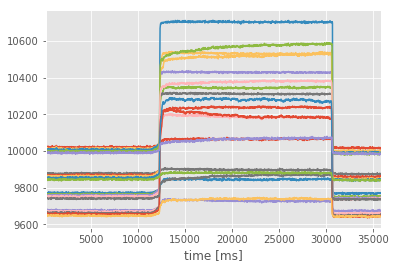

In [2]:
df = pd.read_csv('../data/scan_data_gain200_thumb.csv', header=None, index_col=0)
df.plot(legend=False)
pl.xlabel('time [ms]')
pl.show()

The touch event is clear in the figure, lasting from about 12000 ms to a bit over 30000 ms. The y-axis has arbitrary units, it's just an integer value of the sensor register.

Let's take a closer look at the sensor signals during the touch event. Use a 10-s segment from 15 s to 25 s. For visualization, the individual sensor signals are smoothed by calculating a 10-sample rolling window median, and then the average is taken over all sensors to produce one single timeseries.

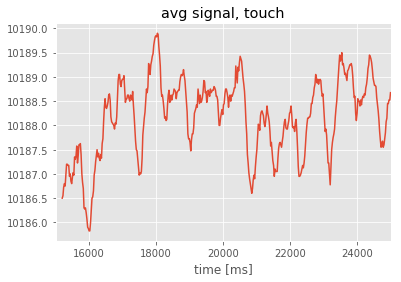

In [3]:
df.loc[15000:25000].rolling(window=10).median().mean(axis=1).plot(
        title='avg signal, touch')
pl.xlabel('time [ms]')
pl.show()

Looks promising, there could be some periodicity in the signal. Check by plotting the autocorrelation with different lags. No median filtering is done this time, the signal is only averaged across all sensors for each timepoint before passing it to the autocorrelation plotting function.

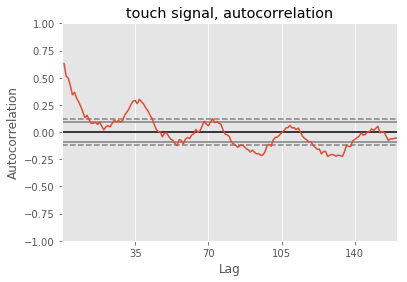

In [4]:
pd.tools.plotting.autocorrelation_plot(df.loc[15000:25000].mean(axis=1))
pl.xlim((0,160))
pl.xticks([35,70,105,140])
pl.grid(which='major',axis='x')
pl.title('touch signal, autocorrelation')
pl.show()

The first and largest peak is at a lag of 35, referring to number of samples. This means that there is periodicity in the signal, and the period is 35 samples long. The dashed and solid lines are the 95% and 99% confidence bands, respectively.

To find out what that translates to in time, calculate the average sampling interval from the dataframe index (the first column in the csv file), and further translate the beat interval into bpm.

In [5]:
avg_sample_rate = np.mean(np.diff(df.index.values))
print('Avg sampling period: %.2f ms, (%d ms – %d ms)' % (
        avg_sample_rate,
        np.min(np.diff(df.index.values)),
        np.max(np.diff(df.index.values))))
print('Period: 35 samples * 21.35 ms = %.2f sec --> %.1f beats / min' % 
      (35*0.001*avg_sample_rate, 60/(35*0.001*avg_sample_rate)))

Avg sampling period: 21.35 ms, (20 ms – 23 ms)
Period: 35 samples * 21.35 ms = 0.75 sec --> 80.3 beats / min


This is really close to the old-school method (see first paragraph above) which gave 84 beats / min. To confirm that we're not just looking at noise that happens to fit our prediction, let's look closer at a segment with no touch (from beginning to 10000 ms).

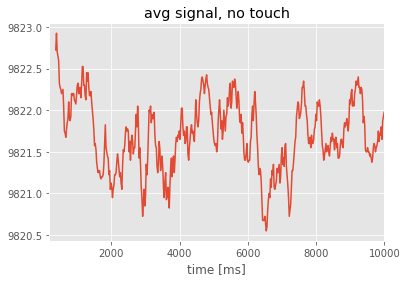

In [6]:
df.loc[:10000].rolling(window=10).median().mean(axis=1).plot(
        title='avg signal, no touch')
pl.xlabel('time [ms]')
pl.show()

There are clearly some fluctuations going on, and even the timing of the peaks (around 1-2 seconds apart) looks like it could be mistaken for heartbeats. Plot the autocorrelation to see if there is any rhytmic temporal pattern which could mess up the heartbeat detection.

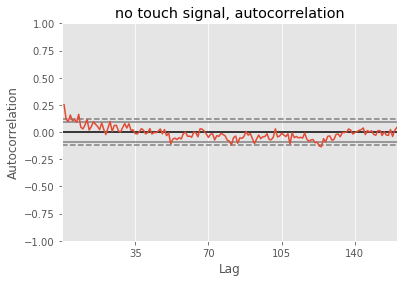

In [7]:
pd.tools.plotting.autocorrelation_plot(df.loc[:10000].mean(axis=1))
pl.xlim((0,160))
pl.xticks([35, 70, 105, 140])
pl.grid(which='major',axis='x')
pl.title('no touch signal, autocorrelation')
pl.show()

Ok, nothing there, so the signal is just noise and we can be quite confident with the heartbeat detection. Success!